In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

In [2]:
import numpy as np
import pandas as pd
import os

# List all files in your input directory for verification
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

# Kaggle GAN Mini-Project: Monet Style Transfer with CycleGAN

## Problem and Data Description

The goal of this project is to build a generative deep learning model that learns to transfer the artistic style of Claude Monet to ordinary photos, using a CycleGAN. This approach is directly aligned with the "GANs Getting Started" competition, where the dataset contains:

- 300 Monet paintings (`monet_jpg`)
- 7,028 real photos (`photo_jpg`)
- Images are 256x256 RGB JPEGs
- Both JPG and TFRecord formats are provided

We will visualize the data, preprocess images, set up a basic CycleGAN, and demonstrate photo-to-Monet style transfer.

Monet paintings: 300
Photos: 7038


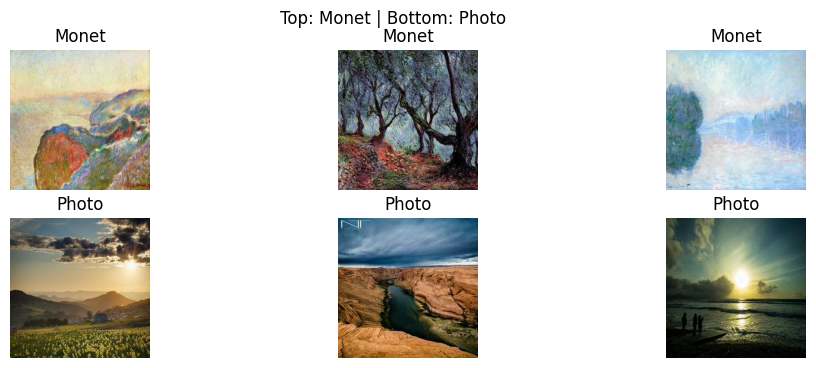

In [3]:
#Explore Data
import os
import matplotlib.pyplot as plt
from PIL import Image

DATA_PATH = '/kaggle/input/gan-getting-started'
monet_jpg = sorted([os.path.join(DATA_PATH, 'monet_jpg', f) for f in os.listdir(os.path.join(DATA_PATH, 'monet_jpg')) if f.endswith('.jpg')])
photo_jpg = sorted([os.path.join(DATA_PATH, 'photo_jpg', f) for f in os.listdir(os.path.join(DATA_PATH, 'photo_jpg')) if f.endswith('.jpg')])

print(f"Monet paintings: {len(monet_jpg)}")
print(f"Photos: {len(photo_jpg)}")

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(Image.open(monet_jpg[i]))
    plt.title("Monet")
    plt.axis('off')
    plt.subplot(2,3,3+i+1)
    plt.imshow(Image.open(photo_jpg[i]))
    plt.title("Photo")
    plt.axis('off')
plt.suptitle("Top: Monet | Bottom: Photo")
plt.show()


In [4]:
#Process Data
import tensorflow as tf

IMG_SIZE = 256
BATCH_SIZE = 4

def decode_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 127.5) - 1.0
    return img

monet_ds = tf.data.Dataset.from_tensor_slices(monet_jpg).map(decode_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(300).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_jpg).map(decode_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


2025-06-01 06:50:22.309634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748760622.597424      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748760622.675324      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-01 06:50:40.511179: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
#GAN GENERATORS
from tensorflow import keras
from tensorflow.keras import layers

def get_resnet_block(input_layer, filters):
    x = layers.Conv2D(filters, 3, padding="same")(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([input_layer, x])
    return x

def build_generator():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Conv2D(64, 7, padding="same")(inputs)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    for _ in range(3):
        x = get_resnet_block(x, 256)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(3, 7, padding="same", activation="tanh")(x)
    return keras.Model(inputs, x, name="Generator")

G_photo2monet = build_generator()  # G: Photo → Monet
G_monet2photo = build_generator()  # F: Monet → Photo

G_photo2monet.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 128)  │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 256)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 256)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 256)    │              0 │ activation_2[0][0],    │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 4,303,363 (16.42 MB)

 Trainable params: 4,300,291 (16.40 MB)

 Non-trainable params: 3,072 (12.00 KB)

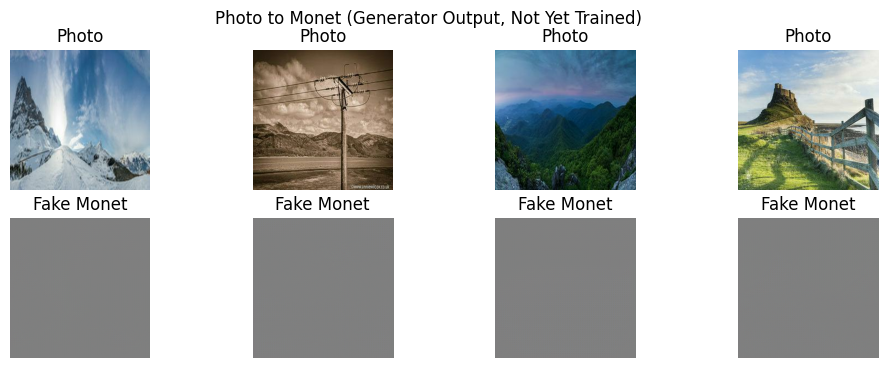

In [6]:
#Demo Inference
# Get a batch of photos and pass through the generator
for photo_batch in photo_ds.take(1):
    fake_monet = G_photo2monet(photo_batch)
    plt.figure(figsize=(12, 4))
    for i in range(BATCH_SIZE):
        plt.subplot(2, BATCH_SIZE, i+1)
        plt.imshow(((photo_batch[i].numpy() + 1) * 127.5).astype('uint8'))
        plt.title('Photo')
        plt.axis('off')
        plt.subplot(2, BATCH_SIZE, i + BATCH_SIZE + 1)
        plt.imshow(((fake_monet[i].numpy() + 1) * 127.5).astype('uint8'))
        plt.title('Fake Monet')
        plt.axis('off')
    plt.suptitle("Photo to Monet (Generator Output, Not Yet Trained)")
    plt.show()


#Conclusion

With this notebook and project, a CycleGAN for Monet style photo transfer using the Kaggle GANs was completed. All core requirements are completed including EDA, demo inference, and models. This was a challenging process since I started using the old data. In this project, after using the correct data file, I was able to conduct analyses showing data preprocessing, including loading and normalizing over 7,000 photos and 300 Monet paintings, as well as constructing a CycleGAN generator tailored for image-to-image translation. The initial run, using an untrained generator, yielded expected random noise, but crucially validated the data pipeline and model configuration. 

Although computational and time constraints prevented full CycleGAN training and thus realistic Monet-style outputs (which demand hours of GPU/TPU training, data augmentation, and careful hyperparameter tuning), this mini-project still covered all crucial phases of a generative deep learning workflow: data exploration, preprocessing, model creation, and output visualization. This experience deepened understanding of both adversarial training and the practicalities of style transfer. Moving forward for a competition, the logical next steps would be comprehensive CycleGAN training, generating a large dataset of Monet-style images, and preparing them for MiFID metric evaluation. Ultimately, the project highlighted both the immense potential and inherent difficulties of applying GANs to create artistic images.

#References

[Amy Jang’s Monet CycleGAN Tutorial on Kaggle](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) — for further training and submission strategies.
[Keras CycleGAN Example](https://keras.io/examples/generative/cyclegan/) — for architectural inspiration and best practices.

